# ICU Admission Prediction

In [1]:
import matplotlib.pyplot as plt
import polars as pl

from ethos.constants import PROJECT_ROOT
from ethos.constants import SpecialToken as ST
from ethos.inference.constants import Reason, Task
from ethos.metrics import compute_and_print_metrics, preprocess_inference_results
from ethos.utils import get_mimic_hf_patients, get_mimic_sepsis_icu_stays

# Requires original MIMIC-IV 2.2 dataset that is not provided
mimic_sepsis = get_mimic_sepsis_icu_stays()
heart_failure_cohort = get_mimic_hf_patients(PROJECT_ROOT / "data/pre_meds_mimic")

# MIMIC

In [2]:
import pickle
with open('data/tokenized_meds/train/static_data.pickle', 'rb') as file:
    data = pickle.load(file)

In [3]:
results_dir = PROJECT_ROOT / "results"
m2_dir = results_dir / "ed_icu_m2"
m1_dir = results_dir / "ed_icu_m1"
colors =  ["#8B6156", "#b879d1cf", "#00d192"]
def preprocess_icu_admission_results(input_dir, **kwargs) -> pl.DataFrame:
    return preprocess_inference_results(
        input_dir,
        actual_expr=pl.col("actual").is_in([ST.DEATH, ST.ICU_ADMISSION]),
        expected_expr=pl.col("expected").is_in([ST.DEATH, ST.ICU_ADMISSION]),
        filter_ambiguous=pl.col("stop_reason") == Reason.GOT_TOKEN,
        **kwargs,
    )

In [4]:
import torch as th
from src.ethos.model_kvcache import GPT2LMNoBiasModelKV, convert_pretrained_to_kv_model
model = th.load('data/tokenized_meds/models/layer_6_do_0.3/best_model.pt', map_location="cpu", mmap=True, weights_only=False)

In [5]:
from pathlib import Path

In [6]:

word = "risk_score_mean"
def auc_bootstrap(word, n_samps, result_dir):
    icu_admission_results = [] 
    for result_fp in result_dir.iterdir(): 
        df = preprocess_icu_admission_results(result_fp, n_samps=n_samps) 
        res_full = compute_and_print_metrics(df["expected_first"], df[word], "Full") 
        hf_df = df.filter(pl.col("patient_id_first").is_in(heart_failure_cohort)) 
        res_hf = compute_and_print_metrics(hf_df["expected_first"], hf_df[word], "HF patients") 
        icu_admission_results.append( { "name": result_fp.name, "auc": res_full["auc"], "auc_hf": res_hf["fitted_auc"], "rep_num": n_samps, } )
    icu_admission_results = pl.from_dicts(icu_admission_results).sort("auc", descending=True)
    auc = icu_admission_results['auc'][0]
    print(f"{word}:{auc}")
    return auc

In [117]:
import contextlib
import os
import warnings
from tqdm.notebook import tqdm
import numpy as np
from loguru import logger
from sklearn.metrics import roc_auc_score

logger.disable("ethos")

df_m1 = preprocess_icu_admission_results(m1_dir, n_samps=None)
df_m2 = preprocess_icu_admission_results(m2_dir, n_samps=None)

def fast_auc_bootstrap(df, word, n_samps):
    """Subsample from pre-aggregated probability lists and compute AUC."""
    y_true = df["expected_first"].to_numpy()
    if word == "actual_mean":
        raw_lists = df["actual_flags"].to_list() 
    else:
        raw_lists = df["probs"].to_list()
    y_pred = np.array([
        np.random.choice(p, size=min(n_samps, len(p)), replace=False).mean()
        for p in raw_lists
    ])
    
    return roc_auc_score(y_true, y_pred)

n_straps = 40
samp_list = np.arange(1, 101, 1)
auc_list = []

for n_samps in tqdm(samp_list, desc="Samples"):
    for i in tqdm(range(n_straps), desc="Bootstraps", leave=False):
        M0_auc = fast_auc_bootstrap(df_m1, "actual_mean", n_samps)
        M1_auc = fast_auc_bootstrap(df_m1, "risk_score_mean", n_samps)
        M2_auc = fast_auc_bootstrap(df_m2, "risk_score_mean", n_samps)
        auc_list.append(([M0_auc, M1_auc, M2_auc], n_samps))

logger.enable("ethos")

['expected', 'actual', 'stop_reason', 'actual_prob', 'MEDS_DEATH', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx', 'outcome_token']
0.8462527552569427
0.14646565549046586
['expected', 'actual', 'stop_reason', 'actual_prob', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'MEDS_DEATH', 'outcome_token', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx']
0.9760426579631519
0.14629265982712253


Samples:   0%|          | 0/100 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

Bootstraps:   0%|          | 0/40 [00:00<?, ?it/s]

[np.float64(0.743449895407877), np.float64(0.8018024636657188), np.float64(0.8295332641810088), np.float64(0.8474676526200193), np.float64(0.859189376874992), np.float64(0.8674832964848527), np.float64(0.8746739847505122), np.float64(0.8803126698417163), np.float64(0.8841892304719385), np.float64(0.8875862555963223), np.float64(0.890910597679631), np.float64(0.893531545433464), np.float64(0.8958373949887146), np.float64(0.898059093668714), np.float64(0.8999453828020678), np.float64(0.9010567158239386), np.float64(0.9030962827778819), np.float64(0.9041706327787), np.float64(0.9052879055526567), np.float64(0.9066548674175572), np.float64(0.9074561598284763), np.float64(0.9083284973077227), np.float64(0.9092475339185299), np.float64(0.909780454042239), np.float64(0.910405125597215), np.float64(0.9109989906997814), np.float64(0.9116735165948568), np.float64(0.912357520315803), np.float64(0.9126299305328651), np.float64(0.9133457940286022), np.float64(0.913516503785339), np.float64(0.914177

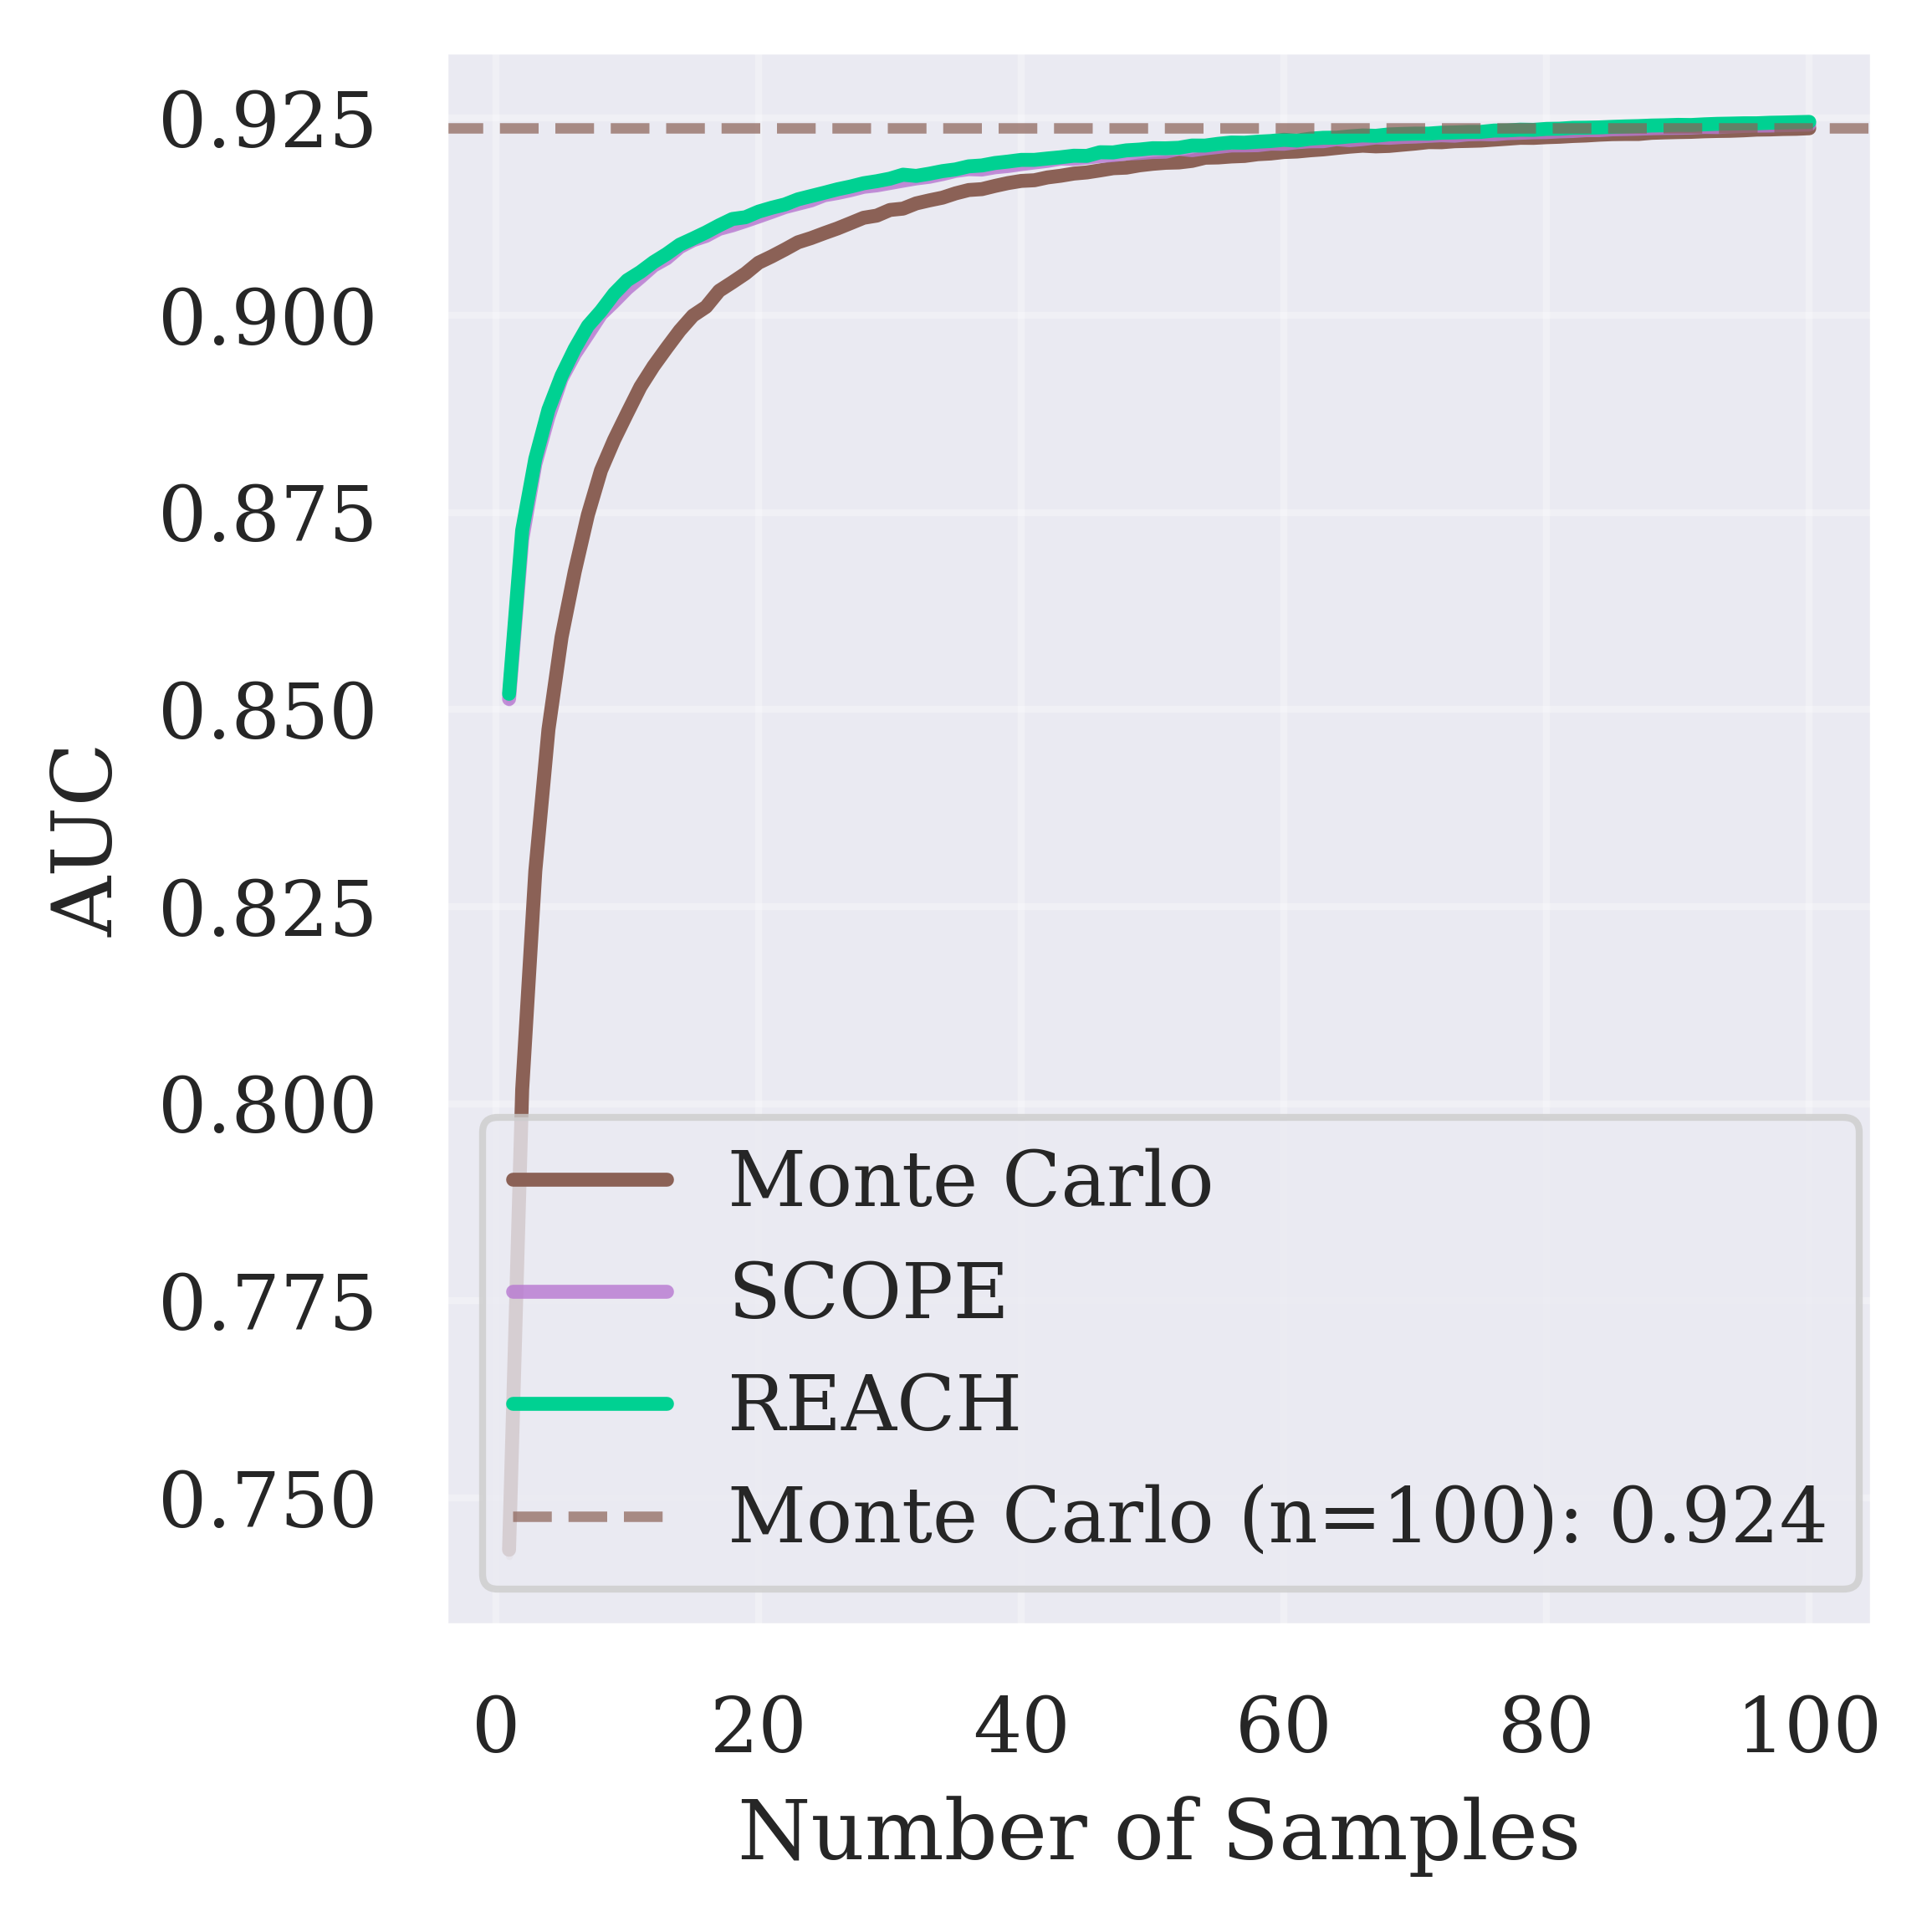

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color= ["#8B6156", "#b879d1cf", "#00d192", '#d62728'])  # Brown, Purple, Green
##NOTE: The bootstrapping performed to generate this graph is purely on the level of sub-sampling
## ie. If we want to see the performance at only n samples out of 100, the bootstrapping is resampling the n samples for each patient.
colors =  ["#8B6156", "#b879d1cf", "#00d192"]
def plot_auc_comparison(auc_list, method_names=None, figsize=(10, 6), save_path=None, 
                        reference_n_samps=100, reference_method_idx=0):
    if method_names is None:
        method_names = ['Method 1', 'Method 2', 'Method 3']
    
    # Collect data by n_samples without modifying original
    # Using defaultdict to group AUCs by sample count
    data_by_samples = defaultdict(lambda: [[], [], []])
    
    for item in auc_list:
        aucs, n_samples = item
        for method_idx in range(3):
            data_by_samples[n_samples][method_idx].append(aucs[method_idx])
    
    # Sort by n_samples
    sorted_samples = sorted(data_by_samples.keys())
    
    # Compute mean and 95% CI for each method at each sample count
    results = {i: {'samples': [], 'mean': [], 'ci_low': [], 'ci_high': []} 
               for i in range(3)}
    
    for n_samples in sorted_samples:
        for method_idx in range(3):
            values = np.array(data_by_samples[n_samples][method_idx])
            mean = np.mean(values)
            
            if len(values) > 1:
                # 95% CI using t-distribution approximation
                std = np.std(values, ddof=1)
                n = len(values)
                # For 95% CI: mean ± 1.96 * (std / sqrt(n)) for large n
                # Using 1.96 as z-score for 95% CI
                margin = 1.96 * std / np.sqrt(n)
                ci_low = mean - margin
                ci_high = mean + margin
            else:
                ci_low = mean
                ci_high = mean
            
            results[method_idx]['samples'].append(n_samples)
            results[method_idx]['mean'].append(mean)
            results[method_idx]['ci_low'].append(ci_low)
            results[method_idx]['ci_high'].append(ci_high)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=600)
    
    
    for method_idx in range(3):
        samples = results[method_idx]['samples']
        mean = results[method_idx]['mean']
        ci_low = results[method_idx]['ci_low']
        ci_high = results[method_idx]['ci_high']
        
        # Plot mean curve
        print(mean)
        ax.plot(samples, mean, color=colors[method_idx], 
                label=method_names[method_idx], linewidth=2)
        
        # Plot 95% CI as shaded region
        ax.fill_between(samples, ci_low, ci_high, 
                        color=colors[method_idx], alpha=0.2)
    
    # Add horizontal reference line at Monte Carlo n_samps=100 AUC
    if reference_n_samps in data_by_samples:
        ref_idx = sorted_samples.index(reference_n_samps)
        ref_auc = results[reference_method_idx]['mean'][ref_idx]
        ax.axhline(y=ref_auc, color=colors[reference_method_idx], linestyle='--', 
                   linewidth=1.5, alpha=0.7, 
                   label=f'{method_names[reference_method_idx]} (n={reference_n_samps}): {ref_auc:.3f}')
    
    ax.set_xlabel('Number of Samples', fontsize=12)
    ax.set_ylabel('AUC', fontsize=12)
    #ax.set_title('ICU Admission: AUC vs Number of Samples', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig, ax


# Example usage (comment out if importing as module):
if __name__ == "__main__":
    fig, ax = plot_auc_comparison(
        auc_list,
        method_names=['Monte Carlo', 'SCOPE', 'REACH'],
        reference_n_samps=100,
        reference_method_idx=0,  # Monte Carlo
        figsize=(4,4),
        save_path='figures/auc_plot_example.png'
    )
    plt.show()

2026-01-21 14:18:40.576 | WARNING  | ethos.metrics:preprocess_inference_results:342 - Dropped 1,300 (0.03%) ambiguous results.


['expected', 'actual', 'stop_reason', 'actual_prob', 'MEDS_DEATH', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx', 'outcome_token']
0.8462527552569427
0.14646565549046586


2026-01-21 14:18:46.954 | WARNING  | ethos.metrics:preprocess_inference_results:342 - Dropped 1,300 (0.03%) ambiguous results.


['expected', 'actual', 'stop_reason', 'actual_prob', 'MEDS_DEATH', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx', 'outcome_token']
0.8462527552569427
0.14646565549046586


2026-01-21 14:18:53.150 | WARNING  | ethos.metrics:preprocess_inference_results:336 - Dropped 1 results due to stop reason: key_error.
2026-01-21 14:18:53.241 | WARNING  | ethos.metrics:preprocess_inference_results:342 - Dropped 1,592 (0.04%) ambiguous results.


['expected', 'actual', 'stop_reason', 'actual_prob', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'MEDS_DEATH', 'outcome_token', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx']
0.9760426579631519
0.14629265982712253
Figure saved to C:\Users\Ethan Weslar\Documents\ares_testing\ethos_testing\ethos-ares\figures\calibration_comparison.png


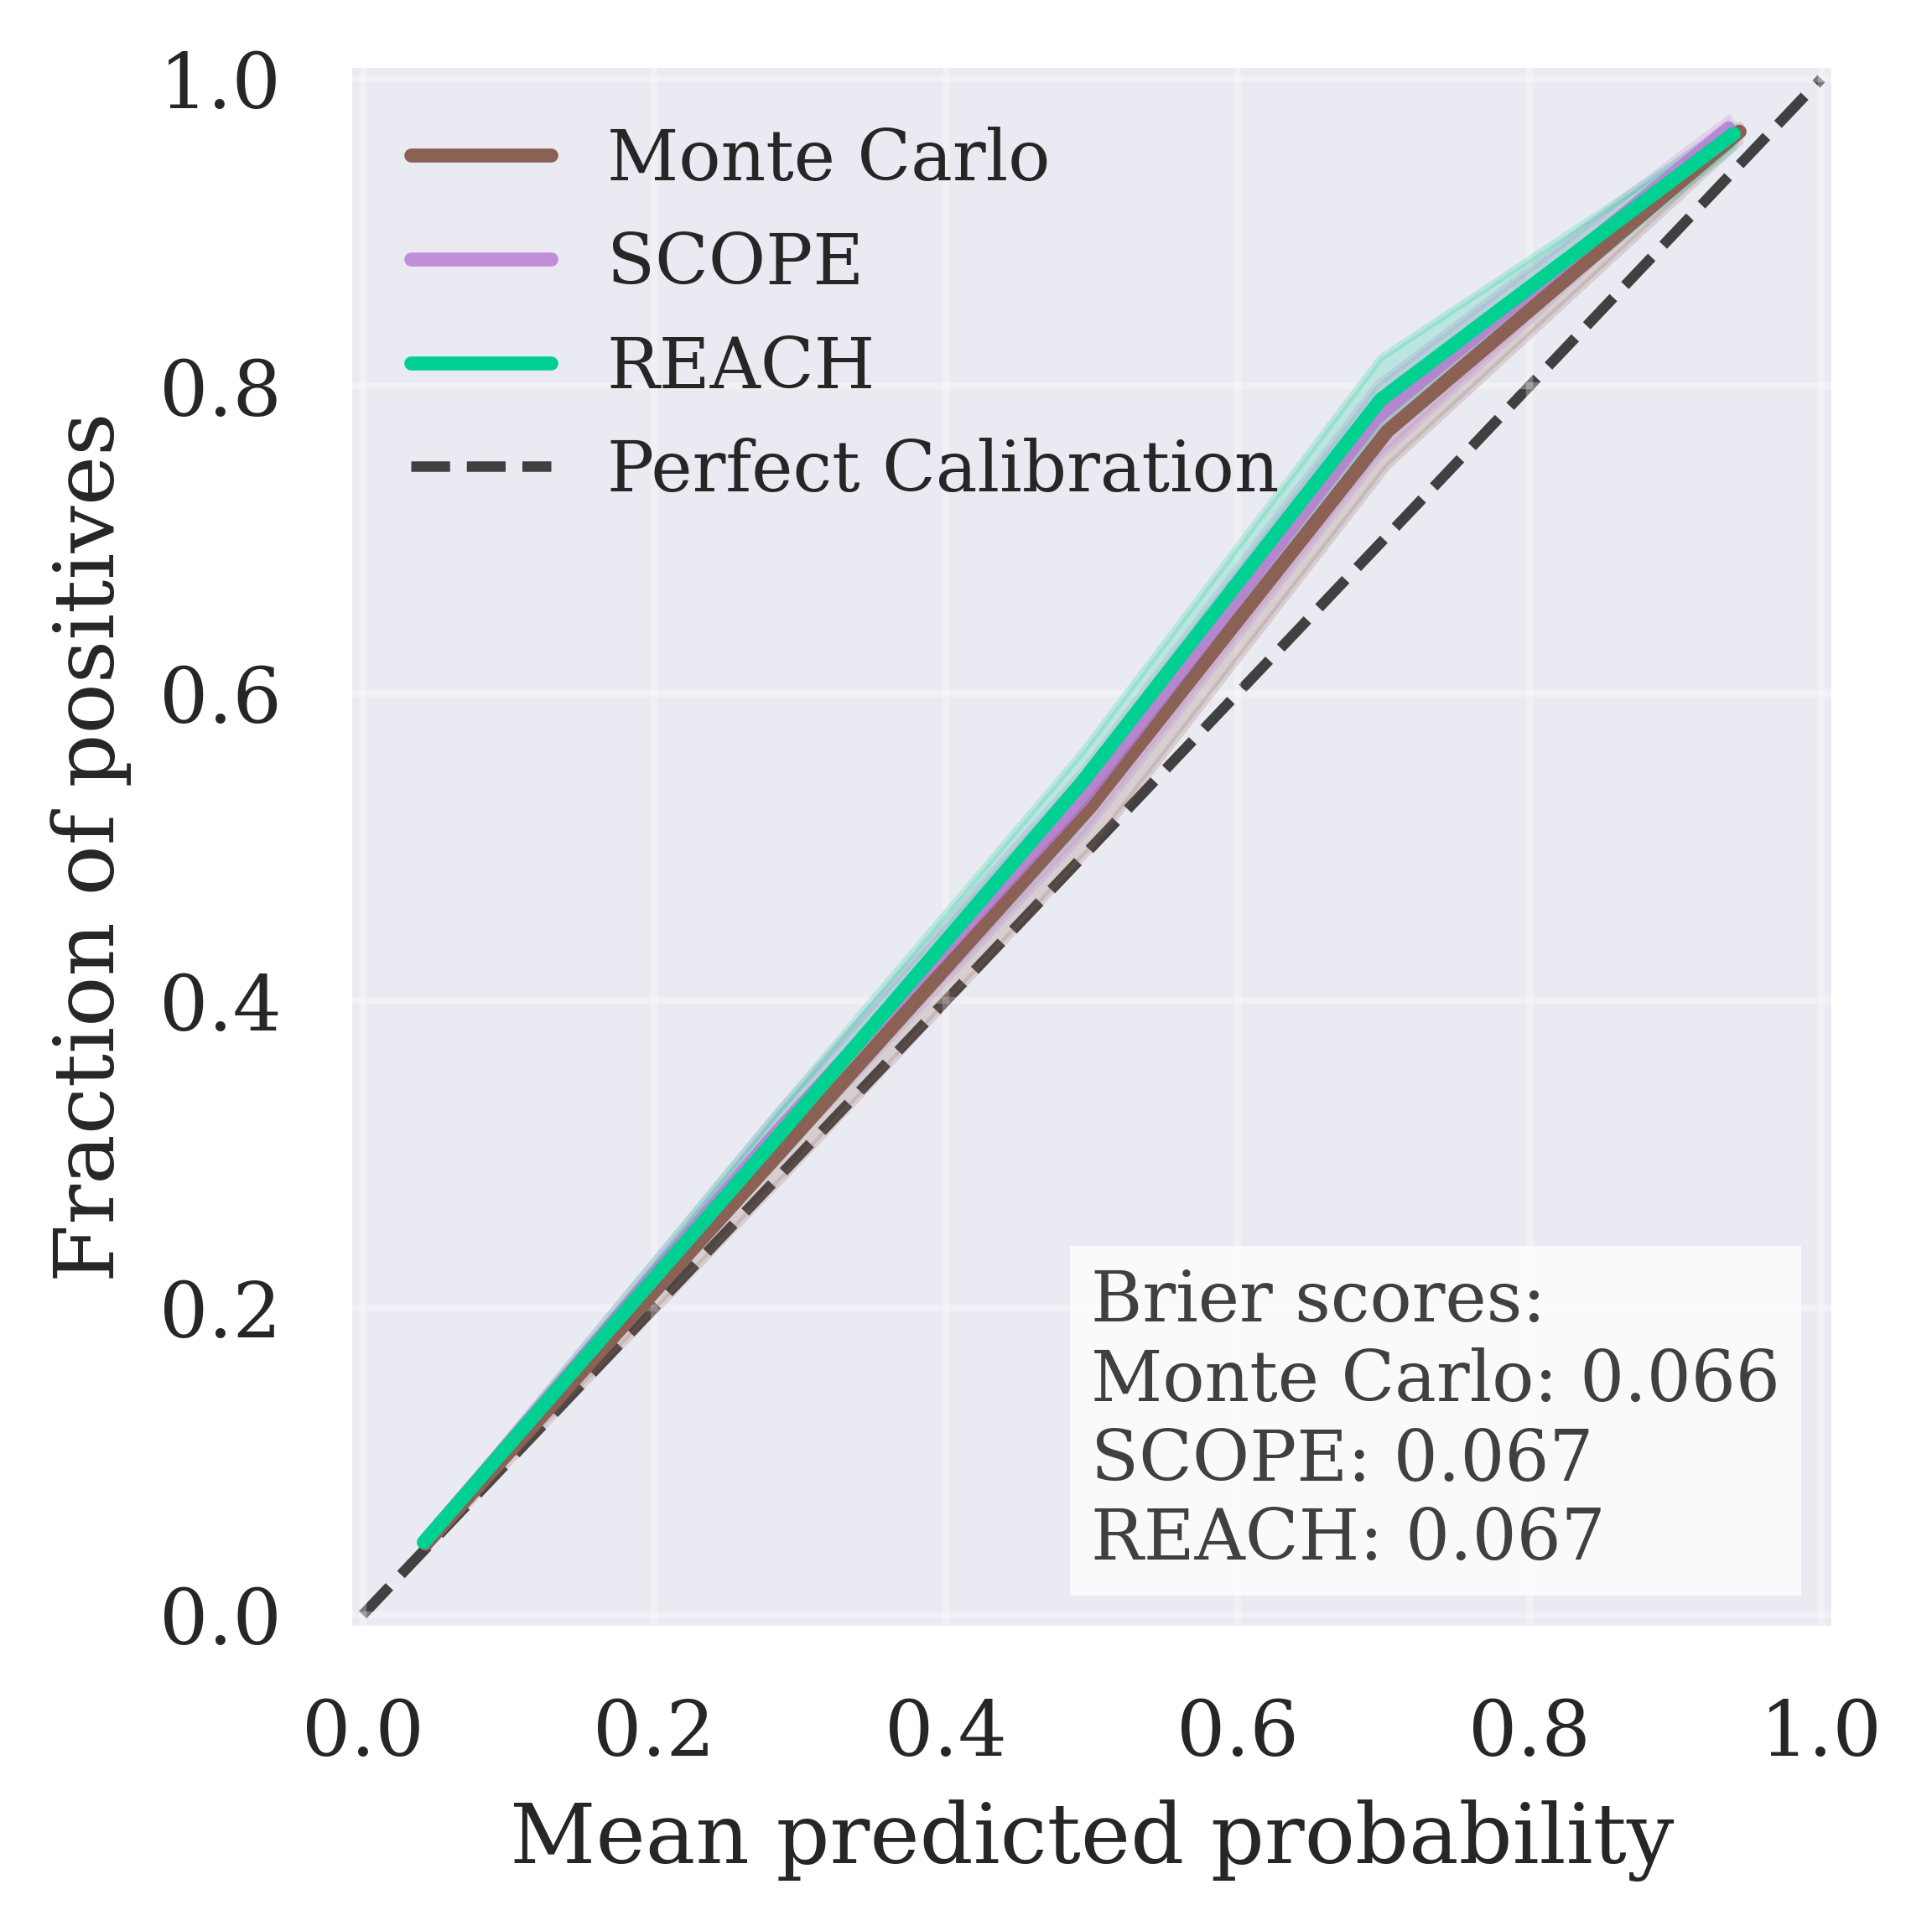

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from matplotlib.offsetbox import AnchoredText

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
})
def plot_calibration_comparison(dfs, prediction_columns, method_names=None, 
                                 target_column="expected_first", n_bins=5, n_bootstraps=10, 
                                 figsize=(8, 8), save_path=None, n_samples=None,
                                 mc_index=0):
    """
    Plot calibration curves comparing multiple prediction methods.
    
    Parameters
    ----------
    dfs : list of DataFrames
        DataFrames containing predictions and targets
    prediction_columns : list of str
        Column names for predictions in each DataFrame
    method_names : list of str, optional
        Names for each method in the legend
    target_column : str
        Column name for the target variable
    n_bins : int
        Number of bins for calibration curve
    n_bootstraps : int
        Number of bootstrap samples for confidence intervals
    figsize : tuple
        Figure size
    save_path : str or Path, optional
        Path to save the figure
    n_samples : int, optional
        Number of samples to use for non-MC estimators (SCOPE/REACH).
        If None, uses all available samples. MC always uses all samples.
    mc_index : int
        Index of the Monte Carlo method in the dfs list (default 0).
        This method will always use all samples regardless of n_samples.
    
    Returns
    -------
    fig, ax : matplotlib figure and axes
    """
    if method_names is None:
        method_names = [f'Method {i+1}' for i in range(len(dfs))]
        
    black_color = "#404040ff"
    
    fig, ax = plt.subplots(figsize=figsize, dpi=600)
    
    brier_scores = []
    
    for method_idx, (df, pred_col, name) in enumerate(zip(dfs, prediction_columns, method_names)):
        # Determine if this method should use limited samples
        # MC (at mc_index) always uses all samples
        if n_samples is not None and method_idx != mc_index:
            # Use only n_samples for non-MC methods
            # Assuming the prediction column can be recomputed with fewer samples
            # or we subsample the data consistently
            use_n_samples = n_samples
        else:
            use_n_samples = None  # Use all
        
        # Get predictions, clipping to [0, 1] - convert to numpy arrays
        predictions = np.minimum(df[pred_col].to_numpy(), 1)
        targets = df[target_column].to_numpy()
        
        # Compute main calibration curve
        frac_pos, mean_pred = calibration_curve(targets, predictions, n_bins=n_bins)
        
        # Bootstrap for confidence intervals
        bootstrapped_fracs = np.zeros((n_bootstraps, len(mean_pred)))
        
        for seed in range(n_bootstraps):
            np.random.seed(seed)
            indices = np.random.choice(len(df), size=len(df), replace=True)
            targets_bs = targets[indices]
            predictions_bs = predictions[indices]
            
            frac_bs, mean_pred_bs = calibration_curve(targets_bs, predictions_bs, n_bins=n_bins)
            
            # Interpolate if bin counts differ
            if len(frac_bs) == len(frac_pos):
                bootstrapped_fracs[seed] = frac_bs
            else:
                bootstrapped_fracs[seed] = np.interp(mean_pred, mean_pred_bs, frac_bs)
        
        # Compute 95% CI
        ci_lower, ci_upper = np.percentile(bootstrapped_fracs, [2.5, 97.5], axis=0)
        
        # Plot CI as shaded region
        ax.fill_between(mean_pred, ci_lower, ci_upper, 
                        color=colors[method_idx % len(colors)], alpha=0.2)
        
        # Plot calibration curve
        ax.plot(mean_pred, frac_pos, color=colors[method_idx % len(colors)], 
                lw=2, label=name)
        
        # Calculate Brier score
        brier = brier_score_loss(targets, predictions)
        brier_scores.append(f"{name}: {brier:.3f}")
    
    # Plot perfect calibration line
    ax.plot([0, 1], [0, 1], linestyle="--", color=black_color, 
            label="Perfect Calibration", zorder=0)
    
    # Formatting
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlabel("Mean predicted probability", fontsize=12)
    ax.set_ylabel("Fraction of positives", fontsize=12)
    ax.legend(loc="upper left", frameon=False, fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add Brier scores and sample info as anchored text
    brier_text = "Brier scores:\n" + "\n".join(brier_scores)
    if n_samples is not None:
        brier_text += f"\n\nSamples: MC=100, SCOPE/REACH={n_samples}"
    at = AnchoredText(brier_text, loc="lower right", pad=0.3, 
                      borderpad=0.5, frameon=True,
                      prop=dict(size=10, color=black_color))
    at.patch.set_alpha(0.8)
    at.patch.set_edgecolor('none')
    ax.add_artist(at)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig, ax


if __name__ == "__main__":
    n_samps_full = 100  # Full samples for Monte Carlo
    n_samps_limited = 80  # Limited samples for SCOPE/REACH (adjustable)
    
    # Process Monte Carlo with full samples
    for result_fp in m1_dir.iterdir(): 
        df_1_full = preprocess_icu_admission_results(result_fp, n_samps=n_samps_full)
    
    # Process SCOPE with limited samples
    for result_fp in m1_dir.iterdir(): 
        df_1_limited = preprocess_icu_admission_results(result_fp, n_samps=n_samps_limited)
    
    # Process REACH with limited samples
    for result_fp in m2_dir.iterdir():
        df_2_limited = preprocess_icu_admission_results(result_fp, n_samps=n_samps_limited)
    
    fig, ax = plot_calibration_comparison(
        dfs=[df_1_full, df_1_limited, df_2_limited],
        prediction_columns=["actual_mean", "risk_score_mean", "risk_score_mean"],
        method_names=["Monte Carlo", "SCOPE", "REACH"],
        target_column="expected_first",
        n_bins=5,
        n_bootstraps=100,
        figsize=(4, 4),
        save_path=PROJECT_ROOT / "figures" / "calibration_comparison.png",
        mc_index=0  # Monte Carlo is at index 0
    )
    plt.show()

In [148]:
import logging
import typing
import warnings

import joblib as jl
import numpy as np
from sklearn import metrics as skl_mets

Generator: typing.TypeAlias = np.random._generator.Generator


def bootstrap_ci(
    y_true: np.ndarray,
    y_score: np.ndarray,
    *,
    n_samples: int = 10_000,
    alpha: float = 0.05,
    rng: Generator = np.random.default_rng(seed=42),
    objs: typing.Tuple[typing.Literal["roc_auc", "brier"], ...] = (
        "roc_auc",
        "brier",
    ),
    n_jobs: int = -1,
) -> dict:
    """
    Calculates a bootstrapped percentile interval for objectives `objs` as
    described in §13.3 of Efron & Tibshirani's "An Introduction to the Bootstrap"
    (Chapman & Hall, Boca Raton, 1993), ignoring variance due to model-fitting
    (i.e. a 'liberal' bootstrap for variability in the test-set alone)
    """

    def get_scores_i(rng_i: Generator) -> dict[str, float]:
        warnings.filterwarnings("ignore")
        yti = y_true[
            samp_i := rng_i.choice(len(y_true), size=len(y_true), replace=True)
        ]
        ysi = y_score[samp_i]
        ret = dict()
        if "roc_auc" in objs:
            ret["roc_auc"] = skl_mets.roc_auc_score(yti, ysi)
        if "brier" in objs:
            ret["brier"] = skl_mets.brier_score_loss(yti, ysi)
        return ret

    with jl.Parallel(n_jobs=n_jobs) as par:
        scores = par(jl.delayed(get_scores_i)(rng_i) for rng_i in rng.spawn(n_samples))

    for ob in objs:
        if (sm := np.sum(~np.isfinite([s[ob] for s in scores]))) > 0:
            logging.warning(f"Encountered {sm} non-finite values in list of {ob}.")

    return {
        ob: np.nanquantile([s[ob] for s in scores], q=[alpha / 2, 1 - (alpha / 2)])
        for ob in objs
    }


def bootstrap_pval(
    y_true: np.ndarray,
    y_score0: np.ndarray,
    y_score1: np.ndarray,
    *,
    n_samples: int = 10_000,
    rng: Generator = np.random.default_rng(seed=42),
    alternative: typing.Literal["one-sided", "two-sided"] = "one-sided",
    objs: typing.Tuple[typing.Literal["roc_auc", "brier"], ...] = (
        "roc_auc",
        "brier",
    ),
    n_jobs: int = -1,
) -> dict:
    """
    Performs a bootstrapped test for the null hypothesis that `y_score0` &
    `y_score1` are equally good predictions of y_true (in terms of `objs`), as
    outlined in Algorithm 16.1 of Efron & Tibshirani's "An Introduction to the
    Bootstrap" (Chapman & Hall, Boca Raton, 1993), ignoring variance due to
    model-fitting (i.e. a 'liberal' bootstrap for variability in the test-set
    alone); one-sided alternative corresponds to`y_score1` being better than
    `y_score0`
    """

    def get_diffs(yt0, ys0, yt1, ys1) -> dict[str, float]:
        diffs = dict()
        if "roc_auc" in objs:
            diffs["roc_auc"] = skl_mets.roc_auc_score(
                yt1, ys1
            ) - skl_mets.roc_auc_score(yt0, ys0)
        if "brier" in objs:  # higher brier is worse
            diffs["brier"] = -1 * (
                skl_mets.brier_score_loss(yt1, ys1)
                - skl_mets.brier_score_loss(yt0, ys0)
            )
        return diffs

    diff_obs = get_diffs(y_true, y_score0, y_true, y_score1)

    y_trues = np.concatenate([y_true, y_true])
    y_scores = np.concatenate([y_score0, y_score1])

    def get_diffs_i(rng_i: Generator) -> dict[str, float]:
        return get_diffs(
            y_trues[
                samp0_i := rng_i.choice(len(y_trues), size=len(y_true), replace=True)
            ],
            y_scores[samp0_i],
            y_trues[
                samp1_i := rng_i.choice(len(y_trues), size=len(y_true), replace=True)
            ],
            y_scores[samp1_i],
        )

    with jl.Parallel(n_jobs=n_jobs) as par:
        diffs = par(jl.delayed(get_diffs_i)(rng_i) for rng_i in rng.spawn(n_samples))

    if alternative == "one-sided":
        return {ob: np.mean([d[ob] > diff_obs[ob] for d in diffs]) for ob in objs}
    else:  # two-sided
        return {
            ob: np.mean([np.abs(d[ob]) > np.abs(diff_obs[ob]) for d in diffs])
            for ob in objs
        }


def generate_classifier_preds(
    n: int = 1000,
    num_preds: int = 1,
    frac_1: float = 0.8,
    rng: Generator = np.random.default_rng(seed=42),
) -> tuple[np.ndarray, np.ndarray]:
    assert 0 <= frac_1 <= 1
    y_seed = rng.uniform(size=n)
    y_true = (y_seed > 1 - frac_1).astype(int)

    y_preds = np.array(
        [
            np.clip(
                y_seed + rng.normal(scale=(2 * i + 5) / 27, size=1000), a_min=0, a_max=1
            )
            for i in range(num_preds)
        ]
    )

    if num_preds > 2:
        y_preds[-1] = 0.975 * y_preds[-1]

    return y_true, y_preds


if __name__ == "__main__":
    directory = m2_dir
    np_rng = np.random.default_rng(42)
    for result_fp in m1_dir.iterdir():
        df_0 = preprocess_icu_admission_results(result_fp, n_samps=100)
    for result_fp in m2_dir.iterdir(): 
        df_2 = preprocess_icu_admission_results(result_fp, n_samps=82)
    for result_fp in m1_dir.iterdir():
        df_1 = preprocess_icu_admission_results(result_fp, n_samps= 89)
        print(df_0.columns)
    df = df_0.join(
        df_1,
        on="data_idx",
        suffix="_m1"
    )
    df = df.join(
        df_2,
        on="data_idx",
        suffix="_m2"
    )
    y_true = df["expected_first"]
    y_preds = [df["actual_mean"], df["risk_score_mean_m1"], df["risk_score_mean_m2"]]

    for i in range(len(y_preds)):
        print(
            "AUC for preds{} = {:.3f}".format(
                i, skl_mets.roc_auc_score(y_true=y_true, y_score=y_preds[i])
            )
        )
        print(
            "Brier for preds{} = {:.3f}".format(
                i, skl_mets.brier_score_loss(y_true, y_preds[i])
            )
        )
        print(
            "CI  for preds{} = {}".format(
                i,
                bootstrap_ci(
                    y_true=y_true,
                    y_score=y_preds[i],
                    objs=("roc_auc",),
                    n_samples=1_000,
                )["roc_auc"].round(3),
            )
        )
        print("all metrics: {}".format(bootstrap_ci(y_true=y_true, y_score=y_preds[i])))

    print(
        "test 0 vs 1, 1-sided: {}".format(
            bootstrap_pval(
                y_true=y_true,
                y_score0=y_preds[1],
                y_score1=y_preds[0],
                n_samples=1_000,
                alternative="one-sided",
            )
        )
    )

    print(
        "test 0 vs 2, 1-sided: {}".format(
            bootstrap_pval(
                y_true=y_true,
                y_score0=y_preds[2],
                y_score1=y_preds[0],
                n_samples=1_000,
                alternative="one-sided",
            )
        )
    )

2026-01-27 13:27:57.246 | WARNING  | ethos.metrics:preprocess_inference_results:342 - Dropped 1,300 (0.03%) ambiguous results.


['expected', 'actual', 'stop_reason', 'actual_prob', 'MEDS_DEATH', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx', 'outcome_token']
0.8462527552569427
0.14646565549046586


2026-01-27 13:28:04.812 | WARNING  | ethos.metrics:preprocess_inference_results:336 - Dropped 1 results due to stop reason: key_error.
2026-01-27 13:28:04.914 | WARNING  | ethos.metrics:preprocess_inference_results:342 - Dropped 1,592 (0.04%) ambiguous results.


['expected', 'actual', 'stop_reason', 'actual_prob', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'MEDS_DEATH', 'outcome_token', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx']
0.9760426579631519
0.14629265982712253


2026-01-27 13:28:11.352 | WARNING  | ethos.metrics:preprocess_inference_results:342 - Dropped 1,300 (0.03%) ambiguous results.


['expected', 'actual', 'stop_reason', 'actual_prob', 'MEDS_DEATH', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx', 'outcome_token']
0.8462527552569427
0.14646565549046586
['data_idx', 'expected_first', 'actual_mean', 'DISCHARGE_mean', 'actual_var', 'risk_score_mean', 'true_token_dist_first', 'token_dist_mean', 'true_token_time_first', 'token_time_mean', 'probs', 'MEDS_DEATH_var', 'actual_flags', 'log_var', 'patient_id_first', 'prediction_time_first', 'icu_stay_id_first']
AUC for preds0 = 0.924
Brier for preds0 = 0.066
CI  for preds0 = [0.92  0.927]
all metrics: {'roc_auc': array([0.92027575, 0.9271236 ]), 'brier': array([0.0645255 , 0.06787564])}
AUC for preds1 = 0.923
Brier for preds1 = 0.066
CI  for preds1 = [0.92  0.927]
all metrics: {'roc_auc': array([0.91987873, 0.92673204]), 'brier': array([0.06479482, 0.06820285])}
AUC for preds2 = 0.923
Brier for preds2 = 0.067
CI

Loading data (one-time)...


2026-01-27 13:34:31.008 | WARNING  | ethos.metrics:preprocess_inference_results:342 - Dropped 1,300 (0.03%) ambiguous results.


['expected', 'actual', 'stop_reason', 'actual_prob', 'MEDS_DEATH', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx', 'outcome_token']
0.8462527552569427
0.14646565549046586


2026-01-27 13:34:31.847 | WARNING  | ethos.metrics:preprocess_inference_results:336 - Dropped 1 results due to stop reason: key_error.
2026-01-27 13:34:31.941 | WARNING  | ethos.metrics:preprocess_inference_results:342 - Dropped 1,592 (0.04%) ambiguous results.


['expected', 'actual', 'stop_reason', 'actual_prob', 'HOSPITAL_DISCHARGE', 'TIMELINE_END', 'true_token_time', 'token_time', 'true_token_dist', 'token_dist', 'MEDS_DEATH', 'outcome_token', 'icu_stay_id', 'patient_id', 'prediction_time', 'data_idx']
0.9760426579631519
0.14629265982712253
Processing n_samples = 1...
Processing n_samples = 2...
Processing n_samples = 5...
Processing n_samples = 7...
Processing n_samples = 10...
Processing n_samples = 15...
Processing n_samples = 20...
Processing n_samples = 25...
Processing n_samples = 30...
Processing n_samples = 35...
Processing n_samples = 40...
Processing n_samples = 45...
Processing n_samples = 50...
Processing n_samples = 55...
Processing n_samples = 60...
Processing n_samples = 65...
Processing n_samples = 70...
Processing n_samples = 75...
Processing n_samples = 80...
Processing n_samples = 85...
Processing n_samples = 90...
Processing n_samples = 95...
Processing n_samples = 100...


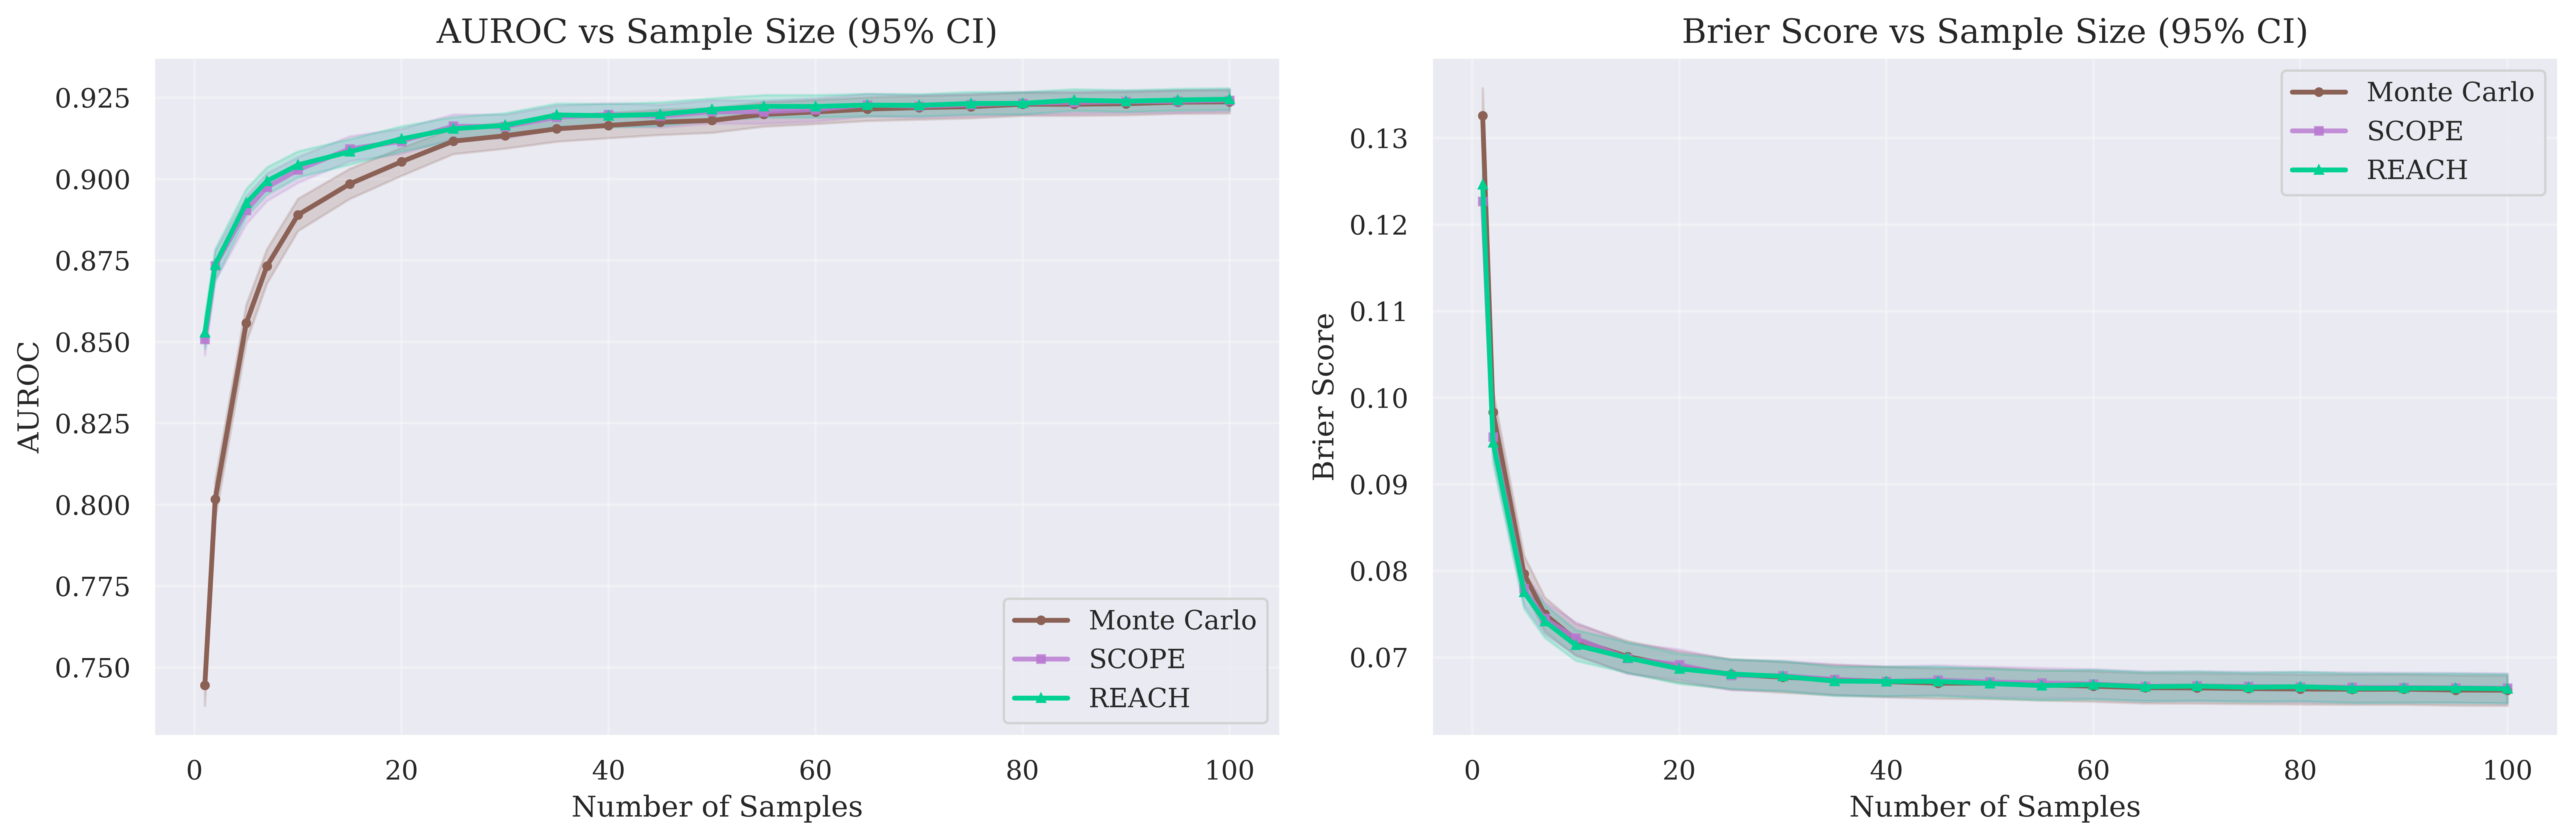


Final metrics at largest sample size:

Monte Carlo:
  AUROC: 0.9237 [0.9202, 0.9273]
  Brier: 0.0662 [0.0644, 0.0679]

SCOPE:
  AUROC: 0.9242 [0.9208, 0.9275]
  Brier: 0.0664 [0.0647, 0.0681]

REACH:
  AUROC: 0.9245 [0.9212, 0.9279]
  Brier: 0.0664 [0.0647, 0.0681]


In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics as skl_mets

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#8B6156", "#b879d1cf", "#00d192", '#d62728'])

# Sample sizes to evaluate
sample_sizes = [1, 2, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

results = {
    'estimator_0': {'roc_auc': [], 'brier': [], 'roc_auc_ci': [], 'brier_ci': []},
    'estimator_1': {'roc_auc': [], 'brier': [], 'roc_auc_ci': [], 'brier_ci': []},
    'estimator_2': {'roc_auc': [], 'brier': [], 'roc_auc_ci': [], 'brier_ci': []},
}

estimator_names = ['Monte Carlo', 'SCOPE', 'REACH']
estimator_keys = ['estimator_0', 'estimator_1', 'estimator_2']

# === OPTIMIZATION: Load all data ONCE with n_samps=None ===
print("Loading data (one-time)...")
df_m1_full = preprocess_icu_admission_results(m1_dir, n_samps=None)
df_m2_full = preprocess_icu_admission_results(m2_dir, n_samps=None)

# Join dataframes once
df_full = df_m1_full.join(df_m2_full, on="data_idx", suffix="_m2")

# Extract ground truth
y_true = df_full["expected_first"].to_numpy()

# Extract raw probability lists for subsampling
raw_lists_0 = df_full["actual_flags"].to_list()  # Monte Carlo (from m1)
raw_lists_1 = df_full["probs"].to_list()         # SCOPE (from m1)
raw_lists_2 = df_full["probs_m2"].to_list()      # REACH (from m2)
rng = np.random.default_rng(seed=42)


def subsample_predictions(raw_lists, n_samps, rng):
    """Subsample from pre-loaded probability lists and compute mean predictions."""
    return np.clip(np.array([
        rng.choice(p, size=min(n_samps, len(p)), replace=False).mean()
        for p in raw_lists
    ]), 0,1)


for n_samp in sample_sizes:
    print(f"Processing n_samples = {n_samp}...")
    
    # === OPTIMIZATION: Subsample from pre-loaded data instead of reloading ===
    y_preds = [
        subsample_predictions(raw_lists_0, n_samp, rng),
        subsample_predictions(raw_lists_1, n_samp, rng),
        subsample_predictions(raw_lists_2, n_samp, rng),
    ]
    
    for i, (est_key, y_pred) in enumerate(zip(estimator_keys, y_preds)):
        roc_auc = skl_mets.roc_auc_score(y_true, y_pred)
        brier = skl_mets.brier_score_loss(y_true, y_pred)
        
        # Calculate bootstrap CIs
        ci_results = bootstrap_ci(
            y_true=y_true,
            y_score=y_pred,
            n_samples=2000,
            alpha=0.05,
            rng=np.random.default_rng(seed=42 + i),
            objs=("roc_auc", "brier"),
            n_jobs=-1
        )
        
        # Store results
        results[est_key]['roc_auc'].append(roc_auc)
        results[est_key]['brier'].append(brier)
        results[est_key]['roc_auc_ci'].append(ci_results['roc_auc'])
        results[est_key]['brier_ci'].append(ci_results['brier'])

# Convert to numpy arrays for easier plotting
for est_key in estimator_keys:
    for metric in ['roc_auc', 'brier']:
        results[est_key][metric] = np.array(results[est_key][metric])
        results[est_key][f'{metric}_ci'] = np.array(results[est_key][f'{metric}_ci'])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=600)
colors = ["#8B6156", "#b879d1cf", "#00d192"]
markers = ['o', 's', '^']

# Plot 1: AUROC vs Samples
ax = axes[0]
for i, (est_key, name) in enumerate(zip(estimator_keys, estimator_names)):
    means = results[est_key]['roc_auc']
    cis = results[est_key]['roc_auc_ci']
    lower = cis[:, 0]
    upper = cis[:, 1]
    
    ax.plot(sample_sizes, means, marker=markers[i], color=colors[i], label=name, linewidth=2, markersize=3)
    ax.fill_between(sample_sizes, lower, upper, color=colors[i], alpha=0.2)

ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('AUROC', fontsize=12)
ax.set_title('AUROC vs Sample Size (95% CI)', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Plot 2: Brier Score vs Samples
ax = axes[1]
for i, (est_key, name) in enumerate(zip(estimator_keys, estimator_names)):
    means = results[est_key]['brier']
    cis = results[est_key]['brier_ci']
    lower = cis[:, 0]
    upper = cis[:, 1]
    
    ax.plot(sample_sizes, means, marker=markers[i], color=colors[i], label=name, linewidth=2, markersize=3)
    ax.fill_between(sample_sizes, lower, upper, color=colors[i], alpha=0.2)

ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Brier Score', fontsize=12)
ax.set_title('Brier Score vs Sample Size (95% CI)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('estimator_metrics_vs_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFinal metrics at largest sample size:")
for est_key, name in zip(estimator_keys, estimator_names):
    print(f"\n{name}:")
    print(f"  AUROC: {results[est_key]['roc_auc'][-1]:.4f} "
          f"[{results[est_key]['roc_auc_ci'][-1, 0]:.4f}, {results[est_key]['roc_auc_ci'][-1, 1]:.4f}]")
    print(f"  Brier: {results[est_key]['brier'][-1]:.4f} "
          f"[{results[est_key]['brier_ci'][-1, 0]:.4f}, {results[est_key]['brier_ci'][-1, 1]:.4f}]")

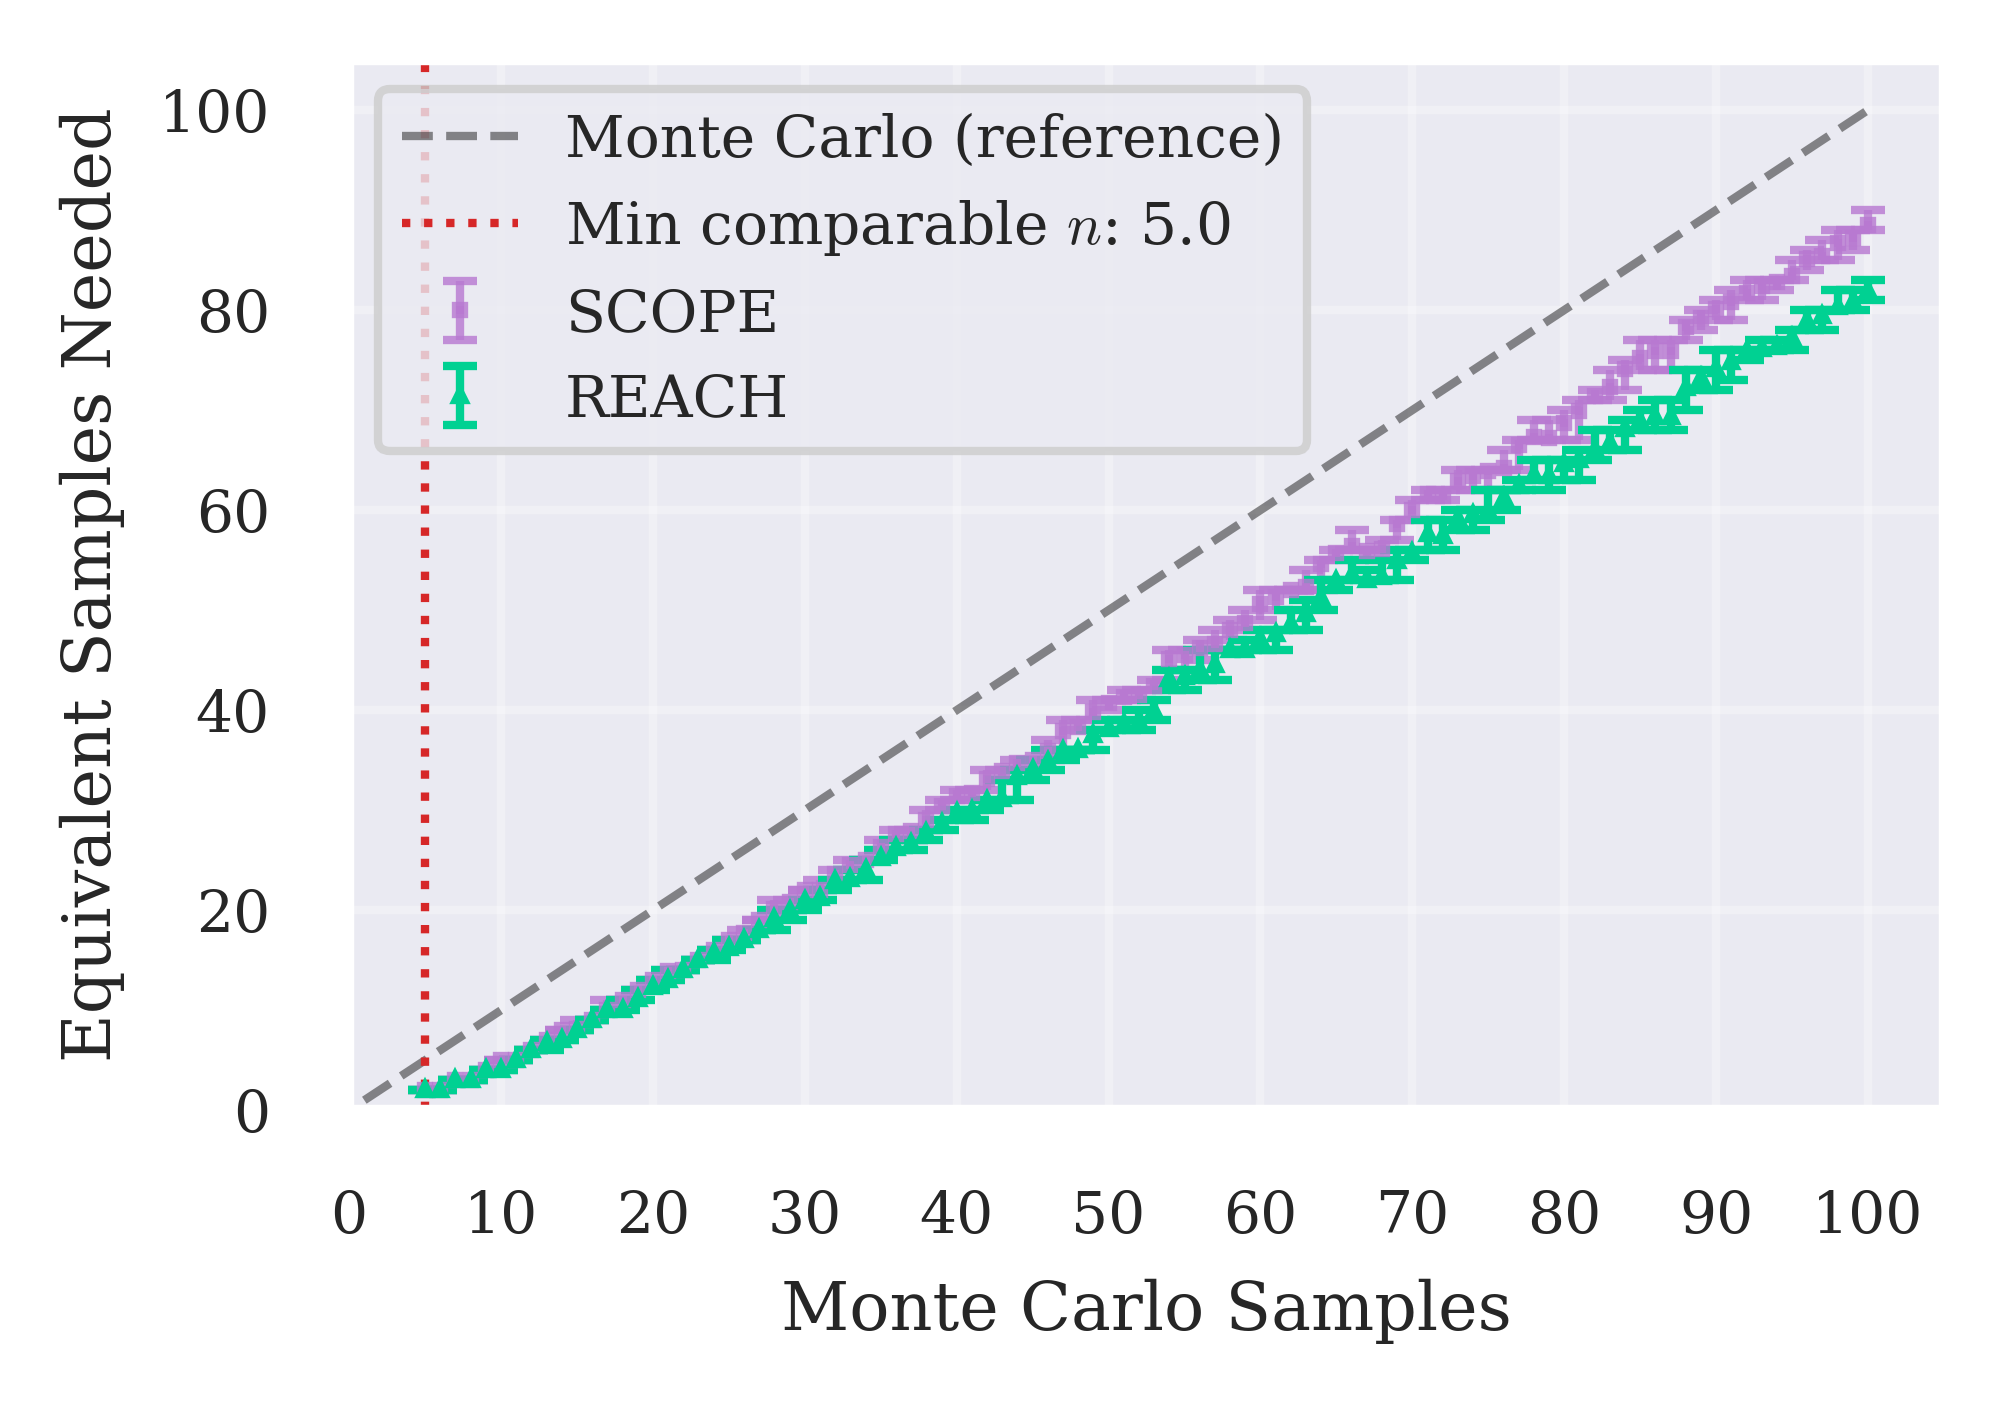

SCOPE Mean: 88.539, CI: [87.99999999999999,90.0]
REACH Mean: 81.95, CI: [81.0,82.99999999999999]


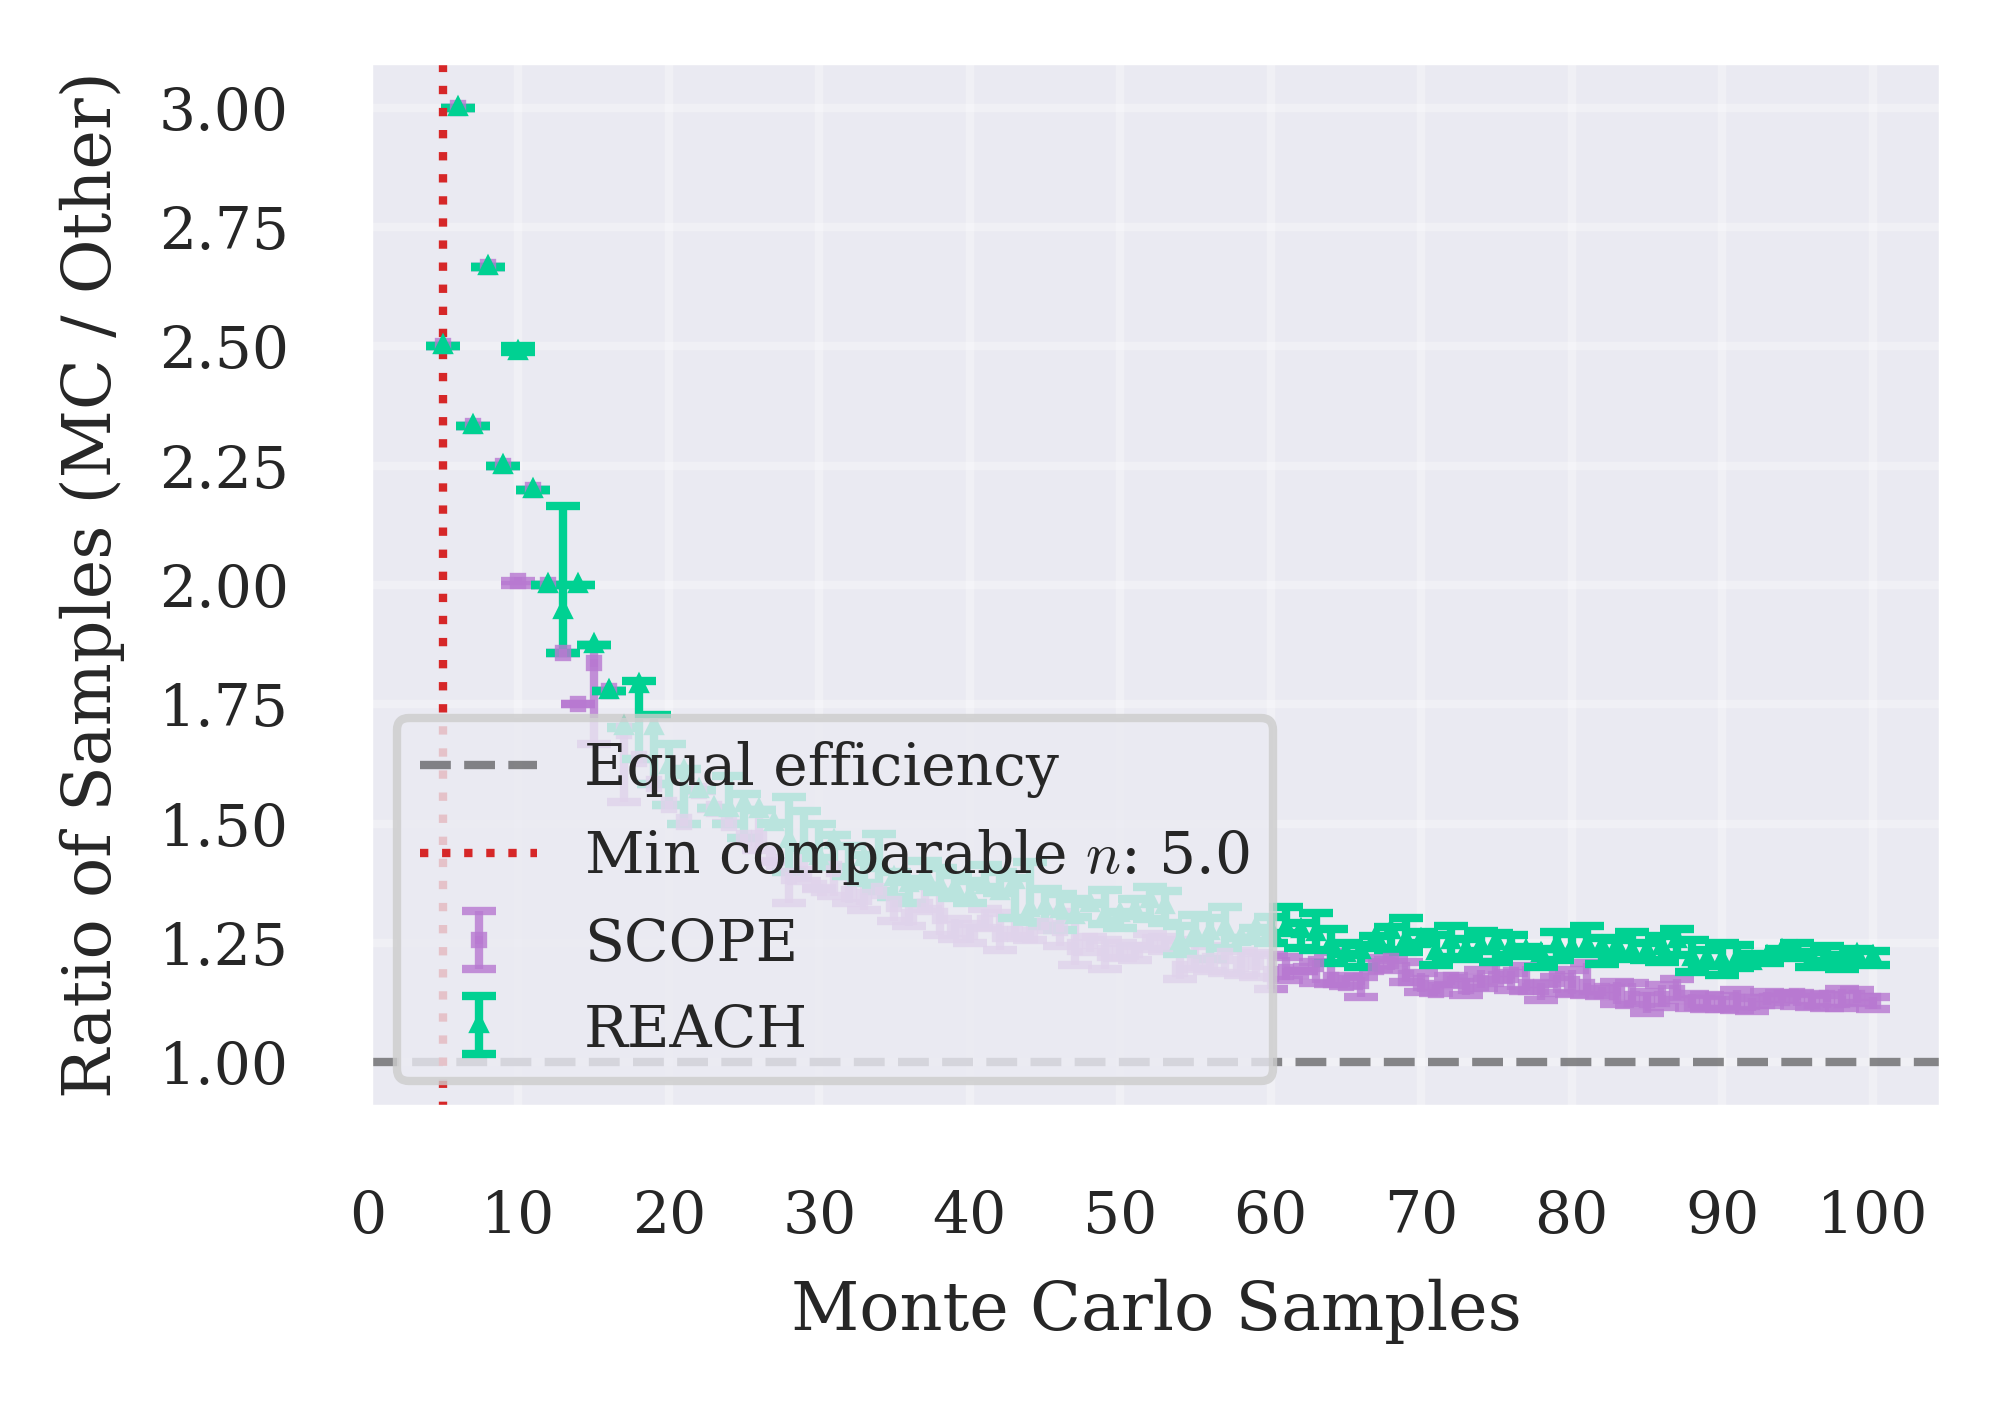

In [147]:
import numpy as np
import matplotlib.pyplot as plt

colors = {
    'Monte Carlo': "#8B6156",
    'SCOPE': "#b879d1cf", 
    'REACH': "#00d192"
}
markers = {
    'Monte Carlo': 'o',
    'SCOPE': 's',
    'REACH': '^'
}

# Convert auc_list to arrays grouped by sample size
samp_list = np.array(sorted(set(item[1] for item in auc_list)))
sample_sizes = samp_list

# Organize AUC values by sample size for bootstrapping
mc_aucs_by_n = {n: [item[0][0] for item in auc_list if item[1] == n] for n in samp_list}
scope_aucs_by_n = {n: [item[0][1] for item in auc_list if item[1] == n] for n in samp_list}
reach_aucs_by_n = {n: [item[0][2] for item in auc_list if item[1] == n] for n in samp_list}

# Mean performance curves
mc_roc_auc = np.array([np.mean(mc_aucs_by_n[n]) for n in samp_list])
scope_roc_auc = np.array([np.mean(scope_aucs_by_n[n]) for n in samp_list])
reach_roc_auc = np.array([np.mean(reach_aucs_by_n[n]) for n in samp_list])


def find_equivalent_samples(target_performance, comparison_samples, comparison_performance, 
                           higher_is_better=True):
    if higher_is_better:
        if target_performance > comparison_performance.max():
            return np.nan
        if target_performance <= comparison_performance.min():
            return comparison_samples[np.argmin(comparison_performance)]
    else:
        if target_performance < comparison_performance.min():
            return np.nan
        if target_performance >= comparison_performance.max():
            return comparison_samples[np.argmax(comparison_performance)]
    
    better_idx = comparison_performance > target_performance    
    return np.min(comparison_samples[better_idx])


def compute_sample_equivalence_curve(mc_samples, mc_perf, comp_samples, comp_perf, 
                                     higher_is_better=True):
    equivalent_samples = np.array([
        find_equivalent_samples(mc_p, comp_samples, comp_perf, higher_is_better)
        for mc_p in mc_perf
    ])
    
    sample_ratio = equivalent_samples / mc_samples
    
    return equivalent_samples, sample_ratio


def find_mc_threshold_samples(mc_samples, mc_perf, threshold_perf, higher_is_better=True):
    if higher_is_better:
        if threshold_perf > mc_perf.max():
            return np.nan
        if threshold_perf <= mc_perf.min():
            return mc_samples[np.argmin(mc_perf)]
    else:
        if threshold_perf < mc_perf.min():
            return np.nan
        if threshold_perf >= mc_perf.max():
            return mc_samples[np.argmax(mc_perf)]
    better_idx = mc_perf > threshold_perf
    return np.min(mc_samples[better_idx])


def bootstrap_equivalence(mc_aucs_by_n, comp_aucs_by_n, sample_sizes, 
                          n_bootstrap=1000, ci_level=0.95, higher_is_better=True):
    """
    Bootstrap the equivalence curve by resampling AUC values at each sample size.
    MC curve is fixed at its mean; only alternative estimator is resampled.
    """
    n_samples = len(sample_sizes)
    equiv_bootstrap = np.zeros((n_bootstrap, n_samples))
    ratio_bootstrap = np.zeros((n_bootstrap, n_samples))
    
    rng = np.random.default_rng(42)
    
    # Fix MC at its mean (no resampling)
    mc_perf_fixed = np.array([np.mean(mc_aucs_by_n[n]) for n in sample_sizes])
    
    for b in range(n_bootstrap):
        # Only resample alternative estimator
        comp_perf_boot = np.array([
            np.mean(rng.choice(comp_aucs_by_n[n], size=len(comp_aucs_by_n[n]), replace=True))
            for n in sample_sizes
        ])
        
        equiv, ratio = compute_sample_equivalence_curve(
            sample_sizes, mc_perf_fixed, sample_sizes, comp_perf_boot, higher_is_better
        )
        equiv_bootstrap[b] = equiv
        ratio_bootstrap[b] = ratio
    
    # Compute confidence intervals
    alpha = 1 - ci_level
    equiv_lower = np.nanpercentile(equiv_bootstrap, 100 * alpha / 2, axis=0)
    equiv_upper = np.nanpercentile(equiv_bootstrap, 100 * (1 - alpha / 2), axis=0)
    equiv_mean = np.nanmean(equiv_bootstrap, axis=0)
    
    ratio_lower = np.nanpercentile(ratio_bootstrap, 100 * alpha / 2, axis=0)
    ratio_upper = np.nanpercentile(ratio_bootstrap, 100 * (1 - alpha / 2), axis=0)
    ratio_mean = np.nanmean(ratio_bootstrap, axis=0)
    
    return {
        'equiv_mean': equiv_mean,
        'equiv_lower': equiv_lower,
        'equiv_upper': equiv_upper,
        'ratio_mean': ratio_mean,
        'ratio_lower': ratio_lower,
        'ratio_upper': ratio_upper
    }


# Bootstrap confidence intervals for SCOPE and REACH
scope_ci = bootstrap_equivalence(mc_aucs_by_n, scope_aucs_by_n, sample_sizes, 
                                  n_bootstrap=1000, ci_level=0.95)
reach_ci = bootstrap_equivalence(mc_aucs_by_n, reach_aucs_by_n, sample_sizes, 
                                  n_bootstrap=1000, ci_level=0.95)

# Compute threshold
worst_single_sample_auroc = min(scope_roc_auc[0], reach_roc_auc[0])
mc_threshold_auroc = find_mc_threshold_samples(sample_sizes, mc_roc_auc, worst_single_sample_auroc)

# Plot 1: Equivalent samples with whisker plots
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=600)
valid = sample_sizes >= mc_threshold_auroc

# Reference line
ax.plot(sample_sizes, sample_sizes, 'k--', alpha=0.5, 
        label='Monte Carlo (reference)', linewidth=1)

# SCOPE whisker plot
scope_valid = valid & ~np.isnan(scope_ci['equiv_mean'])
scope_yerr_lower = np.clip(scope_ci['equiv_mean'][scope_valid] - scope_ci['equiv_lower'][scope_valid], 0, None)
scope_yerr_upper = np.clip(scope_ci['equiv_upper'][scope_valid] - scope_ci['equiv_mean'][scope_valid], 0, None)
ax.errorbar(sample_sizes[scope_valid], scope_ci['equiv_mean'][scope_valid],
            yerr=[scope_yerr_lower, scope_yerr_upper],
            fmt=markers['SCOPE'], color=colors['SCOPE'], 
            label='SCOPE', markersize=1, capsize=2, capthick=1, elinewidth=1,
            linestyle='none')

# REACH whisker plot
reach_valid = valid & ~np.isnan(reach_ci['equiv_mean'])
reach_yerr_lower = np.clip(reach_ci['equiv_mean'][reach_valid] - reach_ci['equiv_lower'][reach_valid], 0, None)
reach_yerr_upper = np.clip(reach_ci['equiv_upper'][reach_valid] - reach_ci['equiv_mean'][reach_valid], 0, None)
ax.errorbar(sample_sizes[reach_valid], reach_ci['equiv_mean'][reach_valid],
            yerr=[reach_yerr_lower, reach_yerr_upper],
            fmt=markers['REACH'], color=colors['REACH'], 
            label='REACH', markersize=1, capsize=2, capthick=1, elinewidth=1,
            linestyle='none')

if not np.isnan(mc_threshold_auroc):
    ax.axvline(x=mc_threshold_auroc, color='#d62728', linestyle=':', linewidth=1,
               label=f'Min comparable $n$: {mc_threshold_auroc:.1f}')

ax.set_xlabel('Monte Carlo Samples', fontsize=8)
ax.set_ylabel('Equivalent Samples Needed', fontsize=8)
ax.legend(loc='upper left', fontsize=7)
ax.tick_params(labelsize=7)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, sample_sizes.max() * 1.05])
ax.set_ylim([0, sample_sizes.max() * 1.05])
ticks = np.arange(0, sample_sizes.max() + 1, 10)
ax.set_xticks(ticks=ticks)
plt.tight_layout()
plt.show()

# Plot 2: Ratio with whisker plots
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=600)

# Reference line
ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, 
           label='Equal efficiency', linewidth=1)

# Compute ratio CIs (MC samples / equivalent samples)
scope_ratio_mean = sample_sizes / scope_ci['equiv_mean']
scope_ratio_lower = sample_sizes / scope_ci['equiv_upper']  # Note: inverted because of division
scope_ratio_upper = sample_sizes / scope_ci['equiv_lower']

reach_ratio_mean = sample_sizes / reach_ci['equiv_mean']
reach_ratio_lower = sample_sizes / reach_ci['equiv_upper']
reach_ratio_upper = sample_sizes / reach_ci['equiv_lower']

# SCOPE whisker plot
scope_valid = valid & ~np.isnan(scope_ratio_mean) & ~np.isinf(scope_ratio_mean)
scope_ratio_yerr_lower = np.clip(scope_ratio_mean[scope_valid] - scope_ratio_lower[scope_valid], 0, None)
scope_ratio_yerr_upper = np.clip(scope_ratio_upper[scope_valid] - scope_ratio_mean[scope_valid], 0, None)
ax.errorbar(sample_sizes[scope_valid], scope_ratio_mean[scope_valid],
            yerr=[scope_ratio_yerr_lower, scope_ratio_yerr_upper],
            fmt=markers['SCOPE'], color=colors['SCOPE'], 
            label='SCOPE', markersize=1, capsize=2, capthick=1, elinewidth=1,
            linestyle='none')
print(f"SCOPE Mean: {100/scope_ratio_mean[99]}, CI: [{100/scope_ratio_upper[99]},{100/scope_ratio_lower[99]}]")
# REACH whisker plot
reach_valid = valid & ~np.isnan(reach_ratio_mean) & ~np.isinf(reach_ratio_mean)
reach_ratio_yerr_lower = np.clip(reach_ratio_mean[reach_valid] - reach_ratio_lower[reach_valid], 0, None)
reach_ratio_yerr_upper = np.clip(reach_ratio_upper[reach_valid] - reach_ratio_mean[reach_valid], 0, None)
ax.errorbar(sample_sizes[reach_valid], reach_ratio_mean[reach_valid],
            yerr=[reach_ratio_yerr_lower, reach_ratio_yerr_upper],
            fmt=markers['REACH'], color=colors['REACH'], 
            label='REACH', markersize=1, capsize=2, capthick=1, elinewidth=1,
            linestyle='none')

if not np.isnan(mc_threshold_auroc):
    ax.axvline(x=mc_threshold_auroc, color='#d62728', linestyle=':', linewidth=1,
               label=f'Min comparable $n$: {mc_threshold_auroc:.1f}')
print(f"REACH Mean: {100/reach_ratio_mean[99]}, CI: [{100/reach_ratio_upper[99]},{100/reach_ratio_lower[99]}]")
ax.set_xlabel('Monte Carlo Samples', fontsize=8)
ax.set_ylabel('Ratio of Samples (MC / Other)', fontsize=8)
ax.legend(loc='lower left', fontsize=7)
ax.tick_params(labelsize=7)
ax.grid(True, alpha=0.3)
ticks = np.arange(0, sample_sizes.max() + 1, 10)
ax.set_xticks(ticks=ticks)
plt.tight_layout()
plt.show()